# **Predicting the "Thermal Comfort" using Ashrae Database**

[Thermal comfort](https://en.wikipedia.org/wiki/Thermal_comfort) is defined as the condition of mind that expresses satisfaction with the thermal environment and is assessed by subjective evaluation. Being a subjective evaluation, in a congregation some people may be satisfied of the climate conditions, others may feel too warm, others too cool. The human body will release excess heat into the environment, so the body can continue to operate. 

Let us look analyse our Ashrae database and predict the "Thermal Comfort" using various classification algorithms and then compare them on various factors. 

**1. Loading the Data**

> Loading different modules required

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import category_encoders as ce
import sklearn
from sklearn.model_selection import train_test_split #splitting the data
from sklearn.ensemble import RandomForestClassifier #Classification using randomforest
from sklearn.metrics import confusion_matrix # mapping the true and false points
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from collections import Counter

> Loading the Ashrae data

In [ ]:
df = pd.read_csv("../input/ashrae-global-thermal-comfort-database-ii/ashrae_db2.01.csv")
df

The Ashrae database we have here, is a huge dataset with 1,07,583 rows and wide set features (70).

This is the description of the dataset, uploaded by the [Data Contributor.](https://www.kaggle.com/claytonmiller/ashrae-global-thermal-comfort-database-ii)

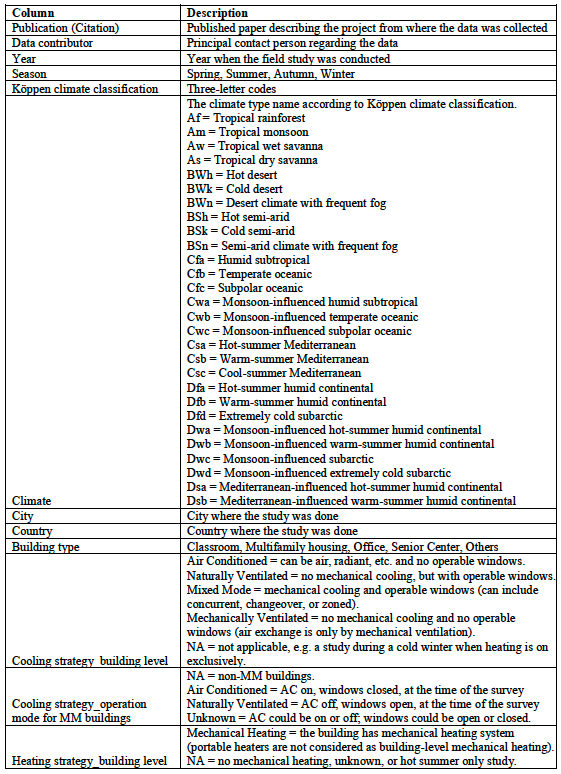

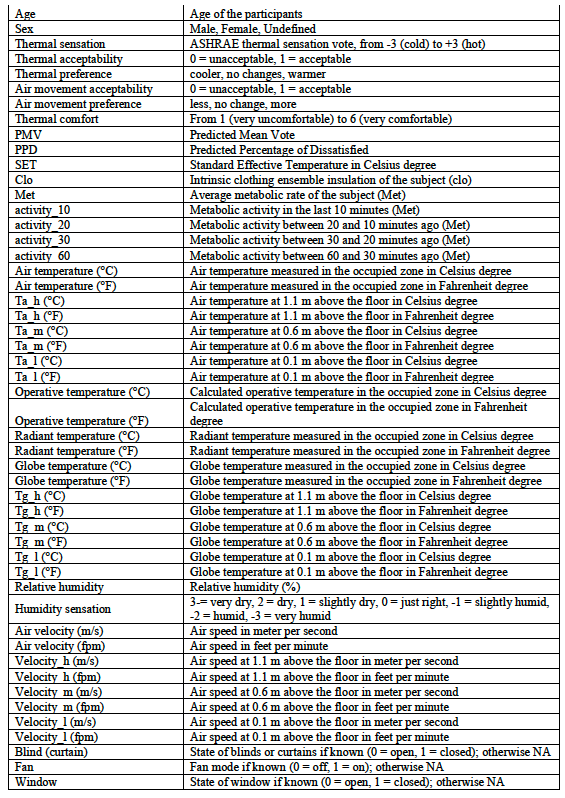

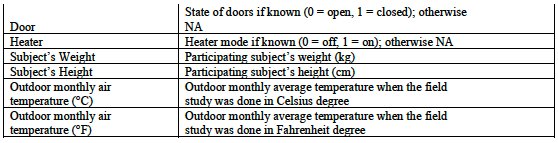

> Checking the number of empty values in each column

**2. Cleaning and Analysing the Data**

In [ ]:
df.isnull().sum()

> Selecting the columns which have less than 67 % Null values 

In [ ]:
# loc[] is primarily label based filtering method, to access a group of rows and columns by label
df = df.loc[:, df.isna().mean() < .67]

Used the number 67 here because there were many columns which were totally empty, so wanted to remove them where there were some important columns like **"Thermal Comfort"** which were crucial for the analysis. Our Analysis is based on "Thermal Comfort" as we it is our target variable (The column which we are predicting). 

> Lets see whats all feature we have for our Analysis

In [ ]:
df.columns

> Let us again check the number of empty data points (rows) in the columns we are left with.

In [ ]:
df.isnull().sum()

> Checking the data types

In [ ]:
df.dtypes

We always need numeric or categorical data type for predictions, so we need to convert "object" data types to categorical. 


Lets check the features which are of the data type object

In [ ]:
# Categories in the "Country" feature
(df['Country'].unique())

In [ ]:
# Publication
df['Publication (Citation)'].unique()

In [ ]:
df['Koppen climate classification'].unique()

In [ ]:
df['Climate'].unique()

In [ ]:
df['Building type'].unique()

In [ ]:
df['Year'].unique()

A point to note here is the feature, year, should not be labelled as numerical data, the data type of year is "float64" which should be converted to categorical data as the collection of data is classified based on the year of collection too. 

In [ ]:
df['Season'].unique()

In [ ]:
df['City'].unique()

In [ ]:
df['Cooling startegy_building level'].unique()

In [ ]:
df['Building type'].unique()

In [ ]:
df['Thermal preference'].unique()

In [ ]:
df['Clo'].unique()

In [ ]:
df['Met'].unique()

Point to note, some of the features has "nan" as an category, but it should not be eliminated unless we weigh the merits of these categories, lets see if this helps us further or else we can simply remove them.

> Thermal Comfort

In [ ]:
# The target variable
df['Thermal comfort'].unique()

In [ ]:
# Also check the values per category
df['Thermal comfort'].value_counts()

Thermal Comfort column is not clean enough to work on, let us keep 6 categories only, we will segragate the data on a scale of integers (1 to 6). Will come back to this part later on in the notebook, now let us clean the whole data.

> Selecting the required columns

In [ ]:
df = df[['Publication (Citation)', 'Data contributor', 'Year', 'Season',
       'Koppen climate classification', 'Climate', 'City', 'Country',
       'Building type', 'Cooling startegy_building level', 'Sex',
       'Thermal sensation',
       'Thermal preference','Clo', 'Met',
       'Air temperature (C)', 'Relative humidity (%)',
       'Air velocity (m/s)',
       'Outdoor monthly air temperature (C)', 'Database', 'Thermal comfort']]

We will be using the columns mentioned above. Dropped the columns which were same, like some features were given in two formats, celsius and fahreinheit 

In [ ]:
df.isnull().sum()

> Dropping the rows with Null values

In [ ]:
df = df.dropna()

> *Cleaning the target variable ~ Thermal Comfort*

In [ ]:
# Checking for outliers in the target variable "Thermal Comfort"
df = df[df['Thermal comfort']!= 'Na']
df = df[df['Thermal comfort']!= 1.3]

# Converting the data to integer so 5.0 and 5 will under one category and outliers would be categorised in nearest integer
df['Thermal comfort'] = df['Thermal comfort'].astype('int64')
df['Thermal comfort'].value_counts()

In [ ]:
# Converting the thermal comfort column back to categorical data type so as to make it cleaner and easier for prediction
df['Thermal comfort'] = df['Thermal comfort'].astype('category')

In [ ]:
df.dtypes

> Converting data type of all columns with "object" to "category"

In [ ]:
df = pd.concat([df.select_dtypes([], ['object']),df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')], axis=1)

In [ ]:
# Checking the data types again after alteration and conversion
df.dtypes

In [ ]:
# Checking for NULL values
df.isnull().sum()

> Ready for the Machine Learning !!

**3. Splitting the Data**

Dividing the data into target variables and feature variables

In [ ]:
y = df['Thermal comfort']
df.drop(['Thermal comfort'],axis = 1, inplace = True)

We will do one hot encoding so as to get the most out of the feature variables. 

What is ["One Hot Encoding"](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179) ? Here are two simple steps to define it.
1. Each unique category value is assigned an integer value. 
2. Then the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [ ]:
# One hot encoding
df = pd.get_dummies(data=df,drop_first=True)

Splitting the data into train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state = 42)

We have splitted the train and test data in ratio of 70:30. We will train the model on our train dataset and then test it on our test set, as the name says.

**4. Fitting the Machine Learning Algorithms**

> We will be using 4 types of classification machine learning algorithms : 
> * Random Forest
> * Naive Bayes
> * Decision Tree 
> * Bagging

> * _Random Forest Classification Algorithm_

In [ ]:
# fitting randomforestclassifier algorithm to the train set
clf = RandomForestClassifier(n_estimators = 540) # ideally the number of estimators in a random forest algorithm should be 10 x number of features
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [ ]:
# Get the Accuracy Score
print('Accuracy : %.4f' % (accuracy_score(y_test, pred)*100))

Plotting the confusion matrix, to describe the performance of our random forest classification model on the set test dataset

In [ ]:
confusion_matrix(y_test, pred)

The horizontal rows of the matrix are the **Actual Values (1-6)** top to bottom and the vertical columns are the **Predicted Values (1-6)** left to right. And the diagnals are the number of correctly mapped values. The accuracy score might not be too high, but if you look at the the number of values assigned as its prior or succesive category is quite high.

Lets try out a few more Machine Learning Algorithms used for Classification

> * _Naive Bayes Classification Algorithm_

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [ ]:
# Get the Accuracy Score
print('Accuracy : %.4f' % (accuracy_score(y_test, pred)*100))

As you can see the accuracy of Naive Bayes algorithm was lesser than that of our previously used random forest algorithm. 

In [ ]:
confusion_matrix(y_test, pred)

What is interesting in the results of Naive Bayes is that, the model predicted values a lot around the upper half of the categorical set (4-6). It has correctly predicted more number of 6's (Very Comfortable) than our previous model, but has failed to classify anything under 1 (Very Uncomfortable).

> * _Decision Tree Classifier_

In [ ]:
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [ ]:
# Get the Accuracy Score
print('Accuracy : %.4f' % (accuracy_score(y_test, pred)*100))

Slightly better than Naive Bayes but not as good as random forest algorithm

In [ ]:
confusion_matrix(y_test, pred)

> * _Bagging Algorithm_

In [ ]:
clf = BaggingClassifier(n_estimators=540)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [ ]:
# Get the Accuracy Score
print('Accuracy : %.4f' % (accuracy_score(y_test, pred)*100))

In [ ]:
confusion_matrix(y_test, pred)

Bagging is also ensemble meta algorithm like randomforest. Bagging has produced a result to our best result produced by randomforest.

Thank you for reading my notebook, if you liked it please **_Upvote_** !